In [1]:
%load_ext autoreload
%autoreload 2
import torch
import yaml
import argparse
import random
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from models.diffusion import Model
from functions.denoising import efficient_generalized_steps
import torchvision.utils as tvu
from datasets import get_dataset, data_transform, inverse_data_transform

In [2]:
# helper functions

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

def seed_worker(worker_id):
    worker_seed = SEED % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a

def efficient_generalized_steps(x, seq, model, b, H_funcs, y_0, sigma_0, etaB, etaA, etaC, cls_fn=None, classes=None):
    with torch.no_grad():
        #setup vectors used in the algorithm
        singulars = H_funcs.singulars()
        Sigma = torch.zeros(x.shape[1]*x.shape[2]*x.shape[3], device=x.device)
        Sigma[:singulars.shape[0]] = singulars
        U_t_y = H_funcs.Ut(y_0)
        Sig_inv_U_t_y = U_t_y / singulars[:U_t_y.shape[-1]]

        #initialize x_T as given in the paper
        largest_alphas = compute_alpha(b, (torch.ones(x.size(0)) * seq[-1]).to(x.device).long())
        largest_sigmas = (1 - largest_alphas).sqrt() / largest_alphas.sqrt()
        large_singulars_index = torch.where(singulars * largest_sigmas[0, 0, 0, 0] > sigma_0)
        inv_singulars_and_zero = torch.zeros(x.shape[1] * x.shape[2] * x.shape[3]).to(singulars.device)
        inv_singulars_and_zero[large_singulars_index] = sigma_0 / singulars[large_singulars_index]
        inv_singulars_and_zero = inv_singulars_and_zero.view(1, -1)     

        # implement p(x_T | x_0, y) as given in the paper
        # if eigenvalue is too small, we just treat it as zero (only for init) 
        init_y = torch.zeros(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]).to(x.device)
        init_y[:, large_singulars_index[0]] = U_t_y[:, large_singulars_index[0]] / singulars[large_singulars_index].view(1, -1)
        init_y = init_y.view(*x.size())
        remaining_s = largest_sigmas.view(-1, 1) ** 2 - inv_singulars_and_zero ** 2
        remaining_s = remaining_s.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3]).clamp_min(0.0).sqrt()
        init_y = init_y + remaining_s * x
        init_y = init_y / largest_sigmas
        
        #setup iteration variables
        x = H_funcs.V(init_y.view(x.size(0), -1)).view(*x.size())
        n = x.size(0)
        seq_next = [-1] + list(seq[:-1])
        x0_preds = []
        xs = [x]

        #iterate over the timesteps
        for i, j in zip(reversed(seq), reversed(seq_next)):
            t = (torch.ones(n) * i).to(x.device)
            next_t = (torch.ones(n) * j).to(x.device)
            at = compute_alpha(b, t.long())
            at_next = compute_alpha(b, next_t.long())
            xt = xs[-1].to(x.device)
            if cls_fn == None:
                et = model(xt, t)
            else:
                et = model(xt, t, classes)
                et = et[:, :3]
                et = et - (1 - at).sqrt()[0,0,0,0] * cls_fn(x,t,classes)
            
            if et.size(1) == 6:
                et = et[:, :3]
            
            x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

            #variational inference conditioned on y
            sigma = (1 - at).sqrt()[0, 0, 0, 0] / at.sqrt()[0, 0, 0, 0]
            sigma_next = (1 - at_next).sqrt()[0, 0, 0, 0] / at_next.sqrt()[0, 0, 0, 0]
            xt_mod = xt / at.sqrt()[0, 0, 0, 0]
            V_t_x = H_funcs.Vt(xt_mod)
            SVt_x = (V_t_x * Sigma)[:, :U_t_y.shape[1]]
            V_t_x0 = H_funcs.Vt(x0_t)
            SVt_x0 = (V_t_x0 * Sigma)[:, :U_t_y.shape[1]]

            falses = torch.zeros(V_t_x0.shape[1] - singulars.shape[0], dtype=torch.bool, device=xt.device)
            cond_before_lite = singulars * sigma_next > sigma_0
            cond_after_lite = singulars * sigma_next < sigma_0
            cond_before = torch.hstack((cond_before_lite, falses))
            cond_after = torch.hstack((cond_after_lite, falses))

            std_nextC = sigma_next * etaC
            sigma_tilde_nextC = torch.sqrt(sigma_next ** 2 - std_nextC ** 2)

            std_nextA = sigma_next * etaA
            sigma_tilde_nextA = torch.sqrt(sigma_next**2 - std_nextA**2)
            
            diff_sigma_t_nextB = torch.sqrt(sigma_next ** 2 - sigma_0 ** 2 / singulars[cond_before_lite] ** 2 * (etaB ** 2))

            #missing pixels
            Vt_xt_mod_next = V_t_x0 + sigma_tilde_nextC * H_funcs.Vt(et) + std_nextC * torch.randn_like(V_t_x0)

            #less noisy than y (after)
            Vt_xt_mod_next[:, cond_after] = \
                V_t_x0[:, cond_after] + sigma_tilde_nextA * ((U_t_y - SVt_x0) / sigma_0)[:, cond_after_lite] + std_nextA * torch.randn_like(V_t_x0[:, cond_after])
            
            #noisier than y (before)
            Vt_xt_mod_next[:, cond_before] = \
                (Sig_inv_U_t_y[:, cond_before_lite] * etaB + (1 - etaB) * V_t_x0[:, cond_before] + diff_sigma_t_nextB * torch.randn_like(U_t_y)[:, cond_before_lite])

            #aggregate all 3 cases and give next prediction
            xt_mod_next = H_funcs.V(Vt_xt_mod_next)
            xt_next = (at_next.sqrt()[0, 0, 0, 0] * xt_mod_next).view(*x.shape)

            x0_preds.append(x0_t.to('cpu'))
            xs.append(xt_next.to('cpu'))


    return xs, x0_preds

In [3]:
# helper variables
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
args = dict2namespace({"exp" : ".", "sigma_0" : 0.01, "image_folder" : "test_folder", "timesteps" : 10, "eta" : 0.85, "etaB" : 1})
cfg_path = "../dd2412/configs/bedroom.yml"
weights_path = "../dd2412/logs/diffusion_models_converted/ema_diffusion_lsun_bedroom_model/model-2388000.ckpt"
SEED = 1234
cls_fn = None

In [4]:
# load a cfg file for model initialization
# the cfg file contains the architecure details for the model which is needed because we use pretrained weights.
# Furhtermore it contains information about the dataset etc. 

with open(cfg_path, "r") as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)

In [5]:
# example on how to use it:
print(f"Number of residual blocks: {config.model.num_res_blocks}")

Number of residual blocks: 2


In [6]:
# now we create a model using the previously loaded config
model = Model(config)

In [7]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 113673219


In [8]:
# now we load the pretrained weights of the model:
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device) # put model on device (e.g. gpu/cpu)

Model(
  (temb): Module(
    (dense): ModuleList(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0-1): 2 x Module(
      (block): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (temb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleList()
      (downsample): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      )
    )
    (2): Module(
      (block): ModuleList(
 

From here on we can use the pretrained model as a denoiser, now we implement the algorithm proposed by the paper. 

**1.) Get the original images $x_0$ and the TO BE degregaded images $y$ (e.g. subsampled/missing data (inpainting))**

In [9]:
# first arguemnt is args, which is basically the path to the image folder
data, test_data = get_dataset(args, config)

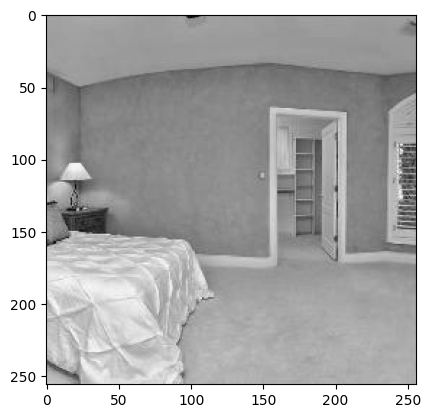

In [10]:
plt.imshow(data[0][0].mean(axis = 0), cmap = "gray")

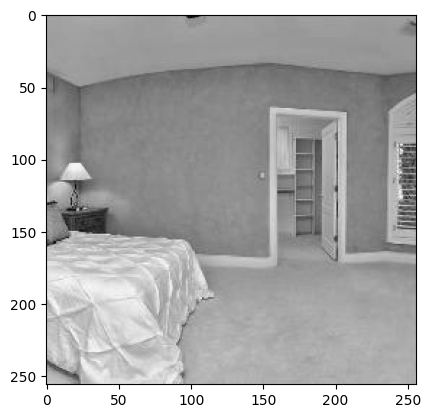

In [11]:
plt.imshow(test_data[0][0].mean(axis = 0), cmap = "gray")

In [12]:
# we can see that the images are not degenerated yet..

In [13]:
# now we generate a dataloader...

g = torch.Generator()
g.manual_seed(SEED)

val_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=config.sampling.batch_size,
    shuffle=True,
    num_workers=config.data.num_workers,
    #worker_init_fn=seed_worker, # does not work here ???
    generator=g,
)

**2.) Get the degragation matrix $H$**

In [14]:
# For now we only focus on one of the problems which is inpainting
from functions.svd_replacement import Inpainting
from functions.svd_replacement import MRI
loaded = np.load("./inp_masks/lorem3.npy")
mask = torch.from_numpy(loaded).to(device).reshape(-1)
missing_r = torch.nonzero(mask == 0).long().reshape(-1) * 3

[]

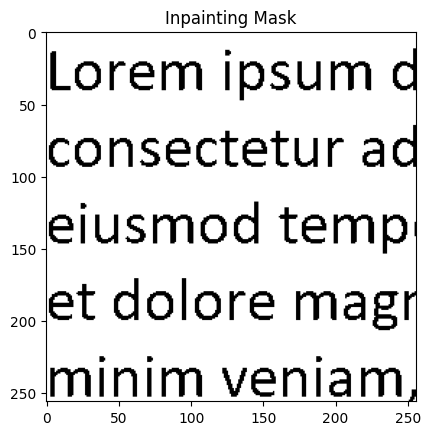

In [15]:
plt.imshow(mask.reshape(256, 256), cmap = "gray")
plt.title("Inpainting Mask")
plt.plot()

In [16]:
missing_g = missing_r + 1
missing_b = missing_g + 1
missing = torch.cat([missing_r, missing_g, missing_b], dim=0)
#H_funcs = Inpainting(config.data.channels, config.data.image_size, missing, device)
under_sample_factor = 2
H_funcs = MRI(config.data.channels, config.data.image_size, under_sample_factor, device)

In [17]:
args.sigma_0 = 2 * args.sigma_0 #to account for scaling to [-1,1]
sigma_0 = args.sigma_0

#### 3.) Restoration algorithm

In [18]:
betas = get_beta_schedule(
    beta_schedule=config.diffusion.beta_schedule,
    beta_start=config.diffusion.beta_start,
    beta_end=config.diffusion.beta_end,
    num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps,
)

betas = torch.from_numpy(betas).float().to(device)
num_timesteps = betas.shape[0]

In [19]:
# TODO STUFF NEEDED FOR THIS FUNCTION!!!!!

def sample_image(x, model, H_funcs, y_0, sigma_0, last=True, cls_fn=None, classes=None):
        skip = num_timesteps // args.timesteps
        seq = range(0, num_timesteps, skip)
        
        x = efficient_generalized_steps(x, seq, model, betas, H_funcs, y_0, sigma_0, \
            etaB=args.etaB, etaA=args.eta, etaC=args.eta, cls_fn=cls_fn, classes=classes)
        if last:
            x = x[0][-1]
        return x

In [20]:
idx_so_far = 0
avg_psnr = 0.0
idx_init = 0.0
for x_orig, classes in tqdm.tqdm(val_loader):
    
    x_orig = x_orig.to(device) # put datatensor on same device as model (DDPM)
    x_orig = data_transform(config, x_orig)

    # degregate the image and add some noise to simulate the "faulty" measurements...
    y_0 = H_funcs.H(x_orig)
    y_0 = y_0 + sigma_0 * torch.randn_like(y_0) 
    
    # only true for inpainting! 
    pinv_y_0 = H_funcs.H_pinv(y_0).view(y_0.shape[0], config.data.channels, config.data.image_size, config.data.image_size)
    
    #pinv_y_0 += H_funcs.H_pinv(H_funcs.H(torch.ones_like(pinv_y_0))).reshape(*pinv_y_0.shape) - 1
    for i in range(len(pinv_y_0)):
        tvu.save_image(
            inverse_data_transform(config, pinv_y_0[i]), os.path.join(args.image_folder, f"y0_{idx_so_far + i}.png")
        )
        tvu.save_image(
            inverse_data_transform(config, x_orig[i]), os.path.join(args.image_folder, f"orig_{idx_so_far + i}.png")
        )
    continue
    # for test purpose if FFT works
    
                ##Begin DDIM
    x = torch.randn(
        y_0.shape[0],
        config.data.channels,
        config.data.image_size,
        config.data.image_size,
        device=device,
        )

            # NOTE: This means that we are producing each predicted x0, not x_{t-1} at timestep t.
    with torch.no_grad():
        x, _ = sample_image(x, model, H_funcs, y_0, sigma_0, last=False, cls_fn=cls_fn, classes=classes)

    x = [inverse_data_transform(config, y) for y in x]

    for i in [-1]: #range(len(x)):
        for j in range(x[i].size(0)):
            tvu.save_image(
                x[i][j], os.path.join(args.image_folder, f"{idx_so_far + j}_{i}.png")
            )
            if i == len(x)-1 or i == -1:
                orig = inverse_data_transform(config, x_orig[j])
                mse = torch.mean((x[i][j].to(device) - orig) ** 2)
                psnr = 10 * torch.log10(1 / mse)
                avg_psnr += psnr

    idx_so_far += y_0.shape[0]
    #pbar.set_description("PSNR: %.2f" % (avg_psnr / (idx_so_far - idx_init)))

    avg_psnr = avg_psnr / (idx_so_far - idx_init)
    print("Total Average PSNR: %.2f" % avg_psnr)
    print("Number of samples: %d" % (idx_so_far - idx_init))


100%|█████████████████████████████████████████████| 2/2 [00:17<00:00,  8.68s/it]


In [372]:
y_0_tmp.shape

torch.Size([6, 3, 256, 256])

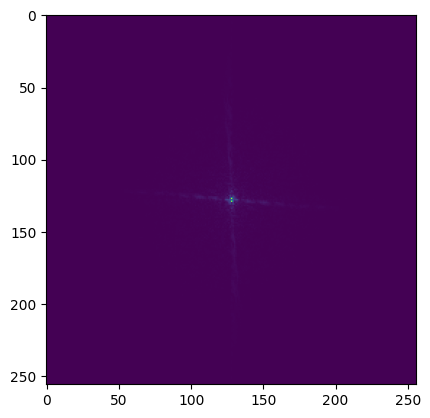

In [68]:
plt.imshow(y_0_tmp[0].mean(axis = 0))

In [73]:
## test to see that degragation of image should look liked

test_img = data[0][0][None, ...]

In [54]:
fft_img = torch.abs(torch.fft.fftshift(torch.fft.fft2(test_img)))

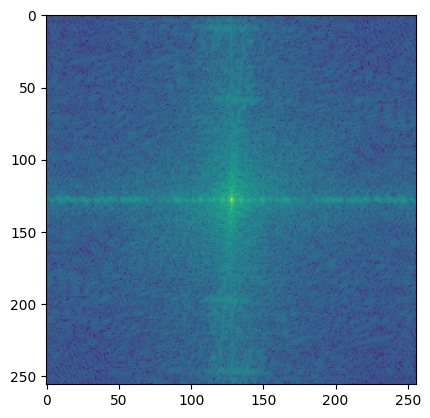

In [58]:
plt.imshow(torch.log(fft_img.mean(axis = 0)))

In [ ]:
### test the implementation of the MRI forward process

In [332]:
under_sample_factor = 2
mri_forward = FFT(config.data.channels, config.data.image_size, under_sample_factor, device)

In [333]:
x = test_img
y = mri_forward.H(x)
x_hat = mri_forward.H_pinv(y)


torch.Size([1, 3, 256, 256])


In [334]:
y = torch.abs(y.view(1, 3, 256, 256))
x_hat = x_hat.view(1, 3, 256, 256)

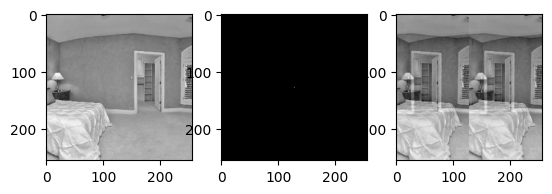

In [335]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(x.mean(axis = (0,1)), cmap = "gray")
ax[1].imshow(y.mean(axis = (0,1)), cmap = "gray")
ax[2].imshow(x_hat.mean(axis = (0,1)), cmap = "gray")

In [270]:
_ = torch.fft.fftshift(torch.fft.fft2(x)).view(x.shape[0], -1)
torch.allclose(mri_forward.H(x), _)

True

In [87]:
renormalized_deg = inverse_data_transform(config, degenerated)

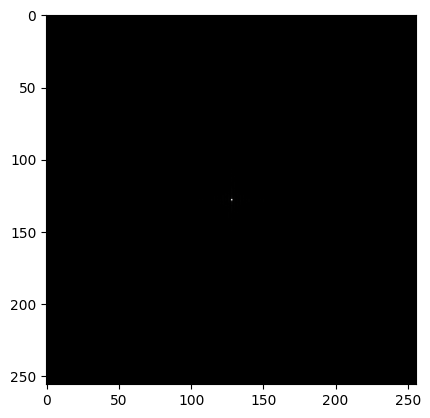

In [141]:
plt.imshow(degenerated[0,...].mean(axis = 0), cmap = 'gray')

In [125]:
usamp_test_img = H_funcs.under_sample(test_img, 6)

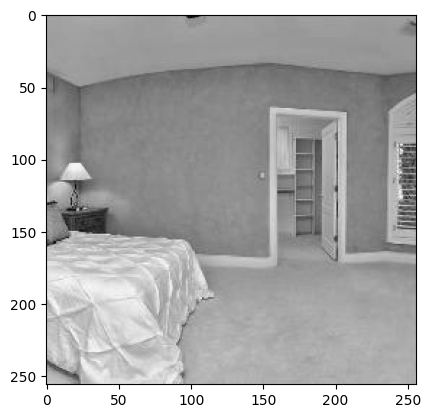

In [126]:
plt.imshow(test_img.mean(axis = (0,1)), cmap = "gray")

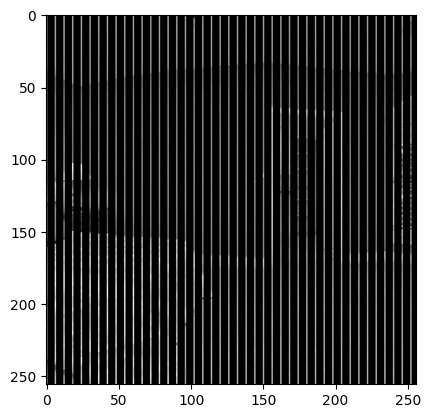

In [127]:
plt.imshow(usamp_test_img.mean(axis = (0,1)), cmap = "gray")